# Task 4.2 - Autoencoder

Next, a UNet based magnetic resonance image segementation of the brain is used. The segmentation accuracy of the model will need to be validated and achieve > 0.9 DSC for all labels. Need to use categorical (one-hot) output in the network and must also visualise some of the segmentation results to justify the DSC (F1) scores obtrained. 

My understanding of U-net is as follows - it is a CNN used for specifically biomedical segmentation. There are two key symmetrical parts - the *encoder* and the *decoder*. What makes a U-net unique is that it includes skip connections from the encoder-decoder symmetr, uses fully convolutional design only with no dense layers, and has a U-shaped design that is fully symmetrical.

Our 'X' input now is the original input, and the 'segmented' images are our 'classification' in the other folder. From the segmented images we can see (with the one hot encoding) that there are 4 key categories each value can fit in:
1. Black (presumably background)
2. Dark Grey (potenitally 'CSF' when looking at online images)
3. Grey (potenitally grey matter when looking at online images)
4. Light Grey (potentially white matter when looking at online images)

Therefore we need to find a way to have the UNET be able to classify each pixel into one of these four categories.

In [77]:
# Import codes
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
import torch.nn.functional as F

import os
from PIL import Image

In [2]:
# Import both datasets
# Import the training images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = 'D:/Files/University/Courses/Year 5/COMP3702/code/lab_2/data/keras_png_slices_data'

X_train_folder = '/keras_png_slices_train/'
X_validate_folder = '/keras_png_slices_validate/'
X_test_folder = '/keras_png_slices_test/'

Y_train_folder = '/keras_png_slices_seg_train/'
Y_validate_folder = '/keras_png_slices_seg_validate/'
Y_test_folder = '/keras_png_slices_seg_test/'

# Transform to convert PIL image to tensor 
transform = transforms.Compose([
    transforms.ToTensor(),                        # Convert to [0, 1] tensor
])

# Load and transform all images
train_image_tensors = []

def import_photos(folder_name):
    image_tensors = []
    
    for filename in os.listdir(path + folder_name):
        if filename.lower().endswith(('.png')):
            img_path = os.path.join(path + folder_name, filename)
            img = Image.open(img_path).convert('L')  # 'L' mode = grayscale
            tensor = transform(img)  # Shape: [1, 256, 256]
            image_tensors.append(tensor)

    # Convert to big tensor
    dataset = torch.stack(image_tensors)
    
    return dataset

X_train_dataset = import_photos(X_train_folder)
X_validate_dataset = import_photos(X_validate_folder)
X_test_dataset = import_photos(X_test_folder)

Y_train_dataset = import_photos(Y_train_folder)
Y_validate_dataset = import_photos(Y_validate_folder)
Y_test_dataset = import_photos(Y_test_folder)

print("Datasets imported successfully.")
print(X_train_dataset.shape) 
print(X_validate_dataset.shape) 
print(X_test_dataset.shape)  
print(Y_train_dataset.shape)
print(Y_validate_dataset.shape)
print(Y_test_dataset.shape)

Datasets imported successfully.
torch.Size([9664, 1, 256, 256])
torch.Size([1120, 1, 256, 256])
torch.Size([544, 1, 256, 256])
torch.Size([9664, 1, 256, 256])
torch.Size([1120, 1, 256, 256])
torch.Size([544, 1, 256, 256])


In [73]:
# Convert the 2nd Channel from a single to 4 for one hot encoding
num_classes = 4

def one_hot_tensor_encoding(dataset, num_classes=4):
    dataset_float = dataset.squeeze(1) # remove the channel
    dataset_integer = (dataset_float * (num_classes - 1)).round().long()
    one_hot_encoded = F.one_hot(dataset_integer, num_classes=num_classes)
    one_hot_encoded = one_hot_encoded.permute(0, 3, 1, 2)
    return one_hot_encoded

Y_train_dataset_encoded = one_hot_tensor_encoding(Y_train_dataset)
Y_validate_dataset_encoded = one_hot_tensor_encoding(Y_validate_dataset)
Y_test_dataset_encoded = one_hot_tensor_encoding(Y_test_dataset)

print(Y_train_dataset_encoded.shape)
print(Y_validate_dataset_encoded.shape)
print(Y_test_dataset_encoded.shape)

torch.Size([9664, 4, 256, 256])
torch.Size([1120, 4, 256, 256])
torch.Size([544, 4, 256, 256])


In [78]:
# As the images are already scaled between 0 and 1, there is no need for further 
# normalization. Instead, just batch the data using DataLoader.

# Load Images
batch_size = 32

train_dataset = TensorDataset(X_train_dataset, Y_train_dataset_encoded)
validation_dataset = TensorDataset(X_validate_dataset, Y_validate_dataset_encoded)
test_dataset = TensorDataset(X_test_dataset, Y_test_dataset_encoded)

# Loaders for training, validation, and testing
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [106]:
# Convert 4 channel segmentation back to single channel for visualisation
def one_hot_to_single_channel_all(one_hot_tensor):
    single_channel = torch.argmax(one_hot_tensor, dim=1, keepdim=True)
    single_channel = single_channel.float() / (one_hot_tensor.shape[1] - 1)
    return single_channel

def one_hot_to_single_channel_single(one_hot_tensor_batch):
    single_channel = torch.argmax(one_hot_tensor_batch, dim=0, keepdim=True)
    single_channel = single_channel.float() / (one_hot_tensor_batch.shape[0] - 1)
    return single_channel

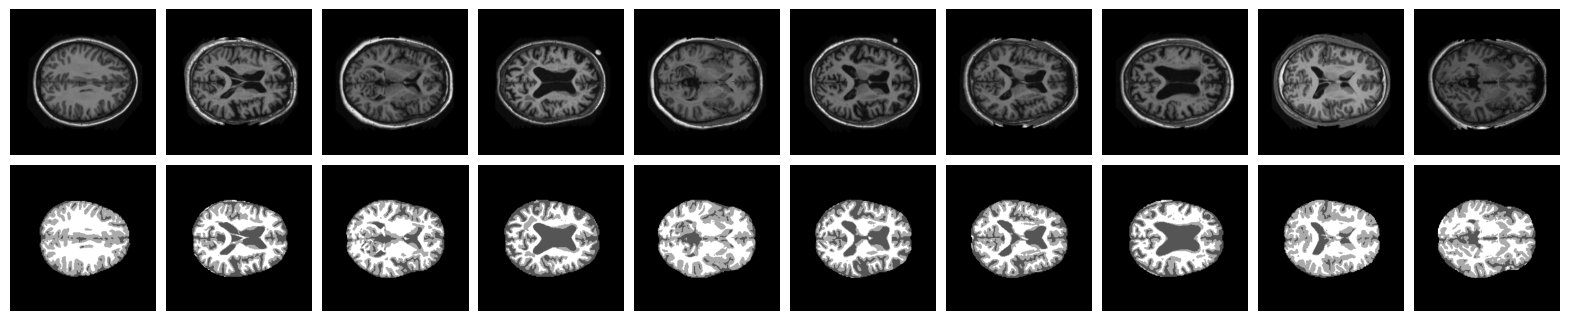

In [ ]:
# get 25 sample training images for visualization
fig = plt.figure(figsize=(20, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 10), axes_pad=0.1)

num_samples = 10
i = 0

for batch_X, batch_Y in train_loader:    
    if i >= num_samples:
        break
    i += 1

    # Get the individual images from the batch
    image_x = batch_X[0].squeeze().cpu().numpy()
    image_y = one_hot_to_single_channel_single(batch_Y[0]).squeeze().cpu().numpy()

    # Plot the X image on the top and y image on the bottom
    grid[i-1].imshow(image_x, cmap='gray')
    grid[i-1].axis('off')
    grid[i-1 + 10].imshow(image_y, cmap='gray')
    grid[i-1 + 10].axis('off')    

plt.show()

In [ ]:
# Generate the U Net model
class uNet(nn.Module):